## Performance of chronos on aquifer data

### Imports

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
import joblib

import time
from datasetsforecast.m3 import M3
from utilsforecast.losses import *
from utilsforecast.evaluation import evaluate
import torch
from chronos import ChronosPipeline

from sklearn.metrics import r2_score

c:\Users\Rok\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Chronos

#### Data preparation

In [3]:
# Read the dataset
aquifer_by_stations = joblib.load('aquifer_by_stations.joblib')

In [4]:
# Ensure the datetime
for key, data in aquifer_by_stations.items():
    data['date'] = pd.to_datetime(data['date'])

Try for only one station

In [5]:
aquifer = aquifer_by_stations[85012]

Mean scaling

In [6]:
def mean_scaling(x):
    mean = np.mean(np.abs(x))

    return x/mean

def standard_scaling(x):
    mean = np.mean(np.abs(x))
    s = np.std(x)

    return (x - mean)/s

def standard_unscaling(original, scaled):
    mean = np.mean(np.abs(original))
    s = np.std(original)

    return (scaled * s) + mean

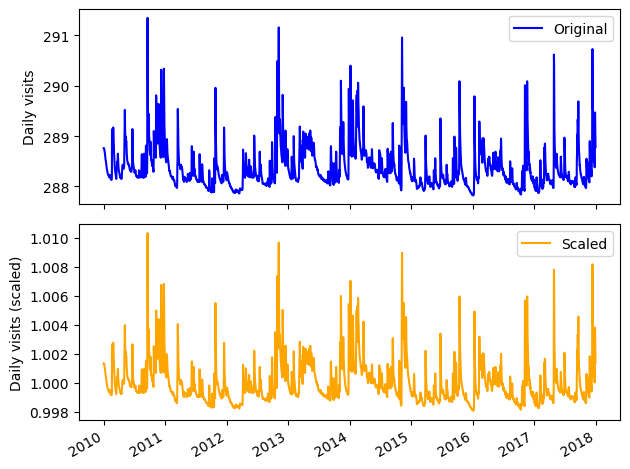

In [9]:
y = aquifer['altitude'].values
y_scaled = mean_scaling(y)

fig, (ax1, ax2) = plt.subplots(ncols=1, nrows=2)

ax1.plot(aquifer['date'], y, color='blue', label='Original')
ax1.set_ylabel('Daily visits')
ax1.legend()

ax2.plot(aquifer['date'], y_scaled, color='orange', label='Scaled')
ax2.set_ylabel('Daily visits (scaled)')
ax2.legend()

fig.autofmt_xdate()
plt.tight_layout()

#### Forecast

In [11]:
# Installs
#%pip install -U git+https://github.com/amazon-science/chronos-forecasting.git
#%pip install neuralforecast

Single forecast

In [12]:
pipeline = ChronosPipeline.from_pretrained(
    "amazon/chronos-t5-large",
    device_map="cuda",
    torch_dtype=torch.bfloat16,
)

horizon = 10
history = 100


chronos_tiny_preds = []

start = time.time()

y = aquifer['altitude'].values
y_scaled = standard_scaling(y)
y = torch.tensor(y_scaled[-history:-horizon])

forecast = pipeline.predict(
    context= y,
    prediction_length=horizon,
    num_samples=20
)

low, median, high = np.quantile(forecast[0].numpy(), [0.1, 0.5, 0.9], axis=0)


chronos_tiny_duration = time.time() - start

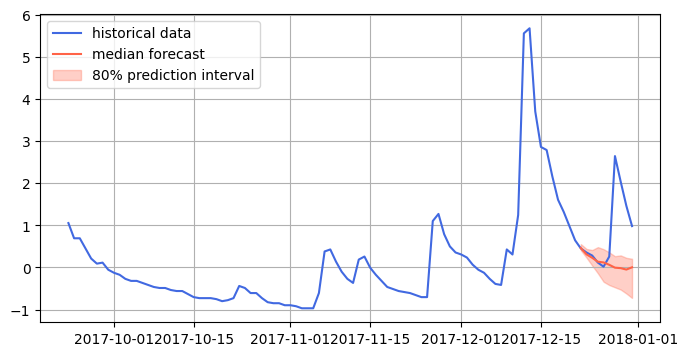

In [14]:
plt.figure(figsize=(8, 4))
plt.plot(aquifer['date'][-100:], y_scaled[-100:], color="royalblue", label="historical data")
plt.plot(aquifer['date'][-horizon:], median, color="tomato", label="median forecast")
plt.fill_between(aquifer['date'][-horizon:], low, high, color="tomato", alpha=0.3, label="80% prediction interval")
plt.legend()
plt.grid()
plt.show()

Sinusoid data

In [15]:
num_points = 1000

# 0 to 20pi range with 1000 points
time_a = np.linspace(0 , 20 * np.pi, num_points)
frequency = 1
amplitude = 0.01  # Amplitude of the sine wave

# Generate the sine wave data
sinusoid = amplitude * np.sin(frequency * time_a)

# Shift the curve up by 1
shifted_sinusoid = sinusoid + 1

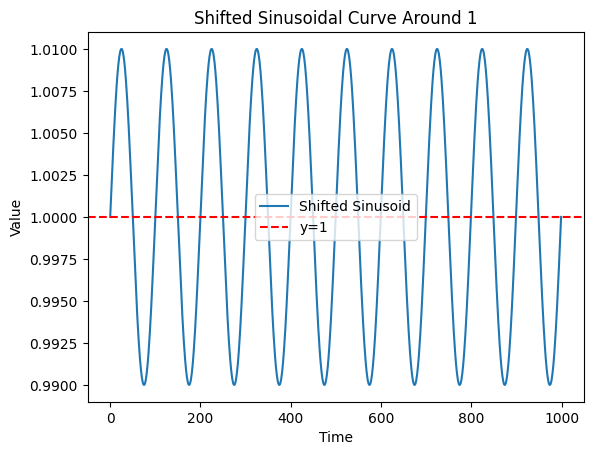

In [16]:
# Plot the shifted sinusoidal curve
plt.plot(shifted_sinusoid, label='Shifted Sinusoid')
plt.title('Shifted Sinusoidal Curve Around 1')
plt.xlabel('Time')
plt.ylabel('Value')
plt.axhline(y=1, color='r', linestyle='--', label='y=1')
plt.legend()
plt.show()

In [17]:
pipeline = ChronosPipeline.from_pretrained(
    "amazon/chronos-t5-tiny",
    device_map="cuda",
    torch_dtype=torch.bfloat16,
)

horizon = 50
history = 1000


chronos_tiny_preds = []


y = torch.tensor(shifted_sinusoid[:-horizon])

forecast = pipeline.predict(
    context= y,
    prediction_length=horizon,
    num_samples=20
)

low, median, high = np.quantile(forecast[0].numpy(), [0.1, 0.5, 0.9], axis=0)

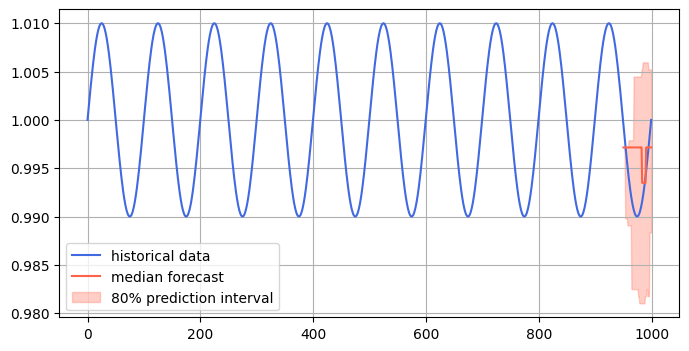

In [18]:
forecast_index = range(num_points - horizon, num_points)

plt.figure(figsize=(8, 4))
plt.plot(shifted_sinusoid, color="royalblue", label="historical data")
plt.plot(forecast_index, median, color="tomato", label="median forecast")
plt.fill_between(forecast_index, low, high, color="tomato", alpha=0.3, label="80% prediction interval")
plt.legend()
plt.grid()
plt.show()

Sinusoid data with scaling

In [19]:
pipeline = ChronosPipeline.from_pretrained(
    "amazon/chronos-t5-tiny",
    device_map="cuda",
    torch_dtype=torch.bfloat16,
)

horizon = 50
history = 1000


chronos_tiny_preds = []

shifted_sinusoid_scaled = standard_scaling(shifted_sinusoid)
y = torch.tensor(shifted_sinusoid_scaled[:-horizon])

forecast = pipeline.predict(
    context= y,
    prediction_length=horizon,
    num_samples=20
)

low, median, high = np.quantile(forecast[0].numpy(), [0.1, 0.5, 0.9], axis=0)

# Unscale the forescasts
low = standard_unscaling(shifted_sinusoid, low)
median = standard_unscaling(shifted_sinusoid, median)
high = standard_unscaling(shifted_sinusoid, high)

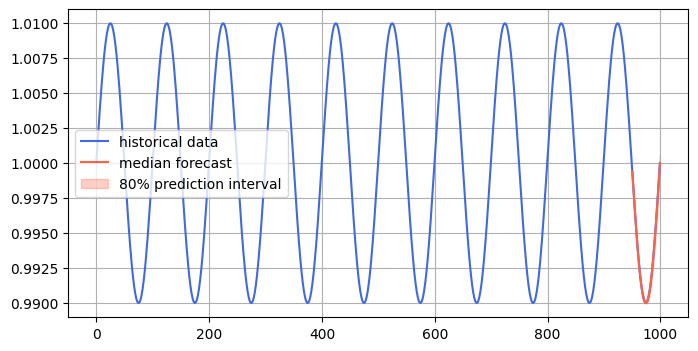

In [20]:
forecast_index = range(num_points - horizon, num_points)

plt.figure(figsize=(8, 4))
plt.plot(shifted_sinusoid, color="royalblue", label="historical data")
plt.plot(forecast_index, median, color="tomato", label="median forecast")
plt.fill_between(forecast_index, low, high, color="tomato", alpha=0.3, label="80% prediction interval")
plt.legend()
plt.grid()
plt.show()

<span style="color:red"><sup>!!! From the sinusoid experiment we found out, that if the data is pretty constant (small deviations), we should use standard scaling on the data, before passing it to chronos. Otherwise most of the predictions can fall into the same bit.</sub></span>

Test dataset (from chronos github repository)

In [21]:
import pandas as pd  # requires: pip install pandas
import torch
from chronos import ChronosPipeline

pipeline = ChronosPipeline.from_pretrained(
    "amazon/chronos-t5-small",
    device_map="cuda",  # use "cpu" for CPU inference and "mps" for Apple Silicon
    torch_dtype=torch.bfloat16,
)

df = pd.read_csv("https://raw.githubusercontent.com/AileenNielsen/TimeSeriesAnalysisWithPython/master/data/AirPassengers.csv")

# context must be either a 1D tensor, a list of 1D tensors,
# or a left-padded 2D tensor with batch as the first dimension
# forecast shape: [num_series, num_samples, prediction_length]
forecast = pipeline.predict(
    context=torch.tensor(df["#Passengers"]),
    prediction_length=12,
    num_samples=20,
)

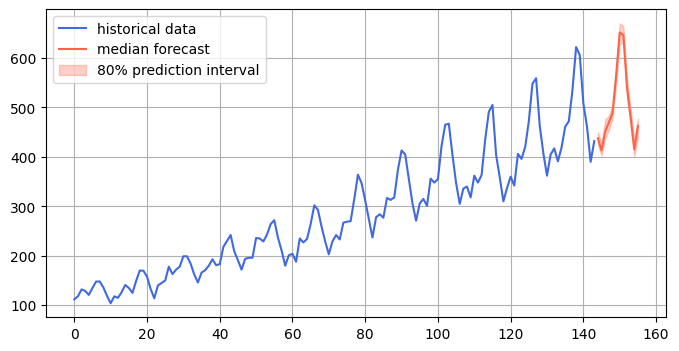

In [23]:
import matplotlib.pyplot as plt  # requires: pip install matplotlib
import numpy as np

forecast_index = range(len(df), len(df) + 12)
low, median, high = np.quantile(forecast[0].numpy(), [0.1, 0.5, 0.9], axis=0)

plt.figure(figsize=(8, 4))
plt.plot(df["#Passengers"], color="royalblue", label="historical data")
plt.plot(forecast_index, median, color="tomato", label="median forecast")
plt.fill_between(forecast_index, low, high, color="tomato", alpha=0.3, label="80% prediction interval")
plt.legend()
plt.grid()
plt.show()

Testing on aquifer data with relative differences in altitude

In [24]:
relative_aquifer = aquifer_by_stations[85012]

In [25]:
pipeline = ChronosPipeline.from_pretrained(
    "amazon/chronos-t5-large",
    device_map="cuda",
    torch_dtype=torch.bfloat16,
)

horizon = 3
history = 100


chronos_tiny_preds = []

start = time.time()

y = relative_aquifer['altitude_diff'].values
y_scaled = standard_scaling(y)
#y_scaled = y
y = torch.tensor(y_scaled[-history:-horizon])

forecast = pipeline.predict(
    context= y,
    prediction_length=horizon,
    num_samples=20
)

low, median, high = np.quantile(forecast[0].numpy(), [0.1, 0.5, 0.9], axis=0)


chronos_tiny_duration = time.time() - start

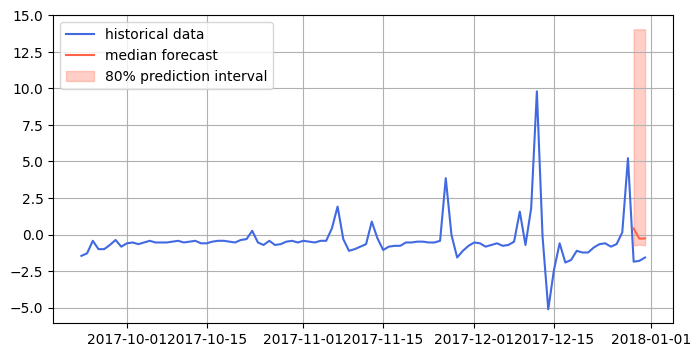

In [26]:

plt.figure(figsize=(8, 4))
plt.plot(relative_aquifer['date'][-100:], y_scaled[-100:], color="royalblue", label="historical data")
plt.plot(relative_aquifer['date'][-horizon:], median, color="tomato", label="median forecast")
plt.fill_between(relative_aquifer['date'][-horizon:], low, high, color="tomato", alpha=0.3, label="80% prediction interval")
plt.legend()
plt.grid()
plt.show()

Testing multiple prediction horizons (without scaling)

In [156]:
relative_aquifer = aquifer_by_stations[85065]

In [157]:
pipeline = ChronosPipeline.from_pretrained(
    "amazon/chronos-t5-large",
    device_map="cuda",
    torch_dtype=torch.bfloat16,
)

horizon = 5
history = 100

day_1 = []
day_2 = []
day_3 = []
day_4 = []
day_5 = []

day_len = 200

# Iterate from day_len days before the end, to the last day
for i in range(day_len + 4, 0, -1):
    y = relative_aquifer['altitude_diff'].values
    y = torch.tensor(y[:-i])
    
    forecast = pipeline.predict(
        context= y,
        prediction_length=horizon,
        num_samples=20
    )
    
    low, median, high = np.quantile(forecast[0].numpy(), [0.1, 0.5, 0.9], axis=0)

    # store the results
    day_1.append(median[0])
    day_2.append(median[1])
    day_3.append(median[2])
    day_4.append(median[3])
    day_5.append(median[4])


In [158]:
# Clean up the results
day_1 = day_1[-200:]
day_2 = day_2[3:-1]
day_3 = day_3[2:-2]
day_4 = day_4[1:-3]
day_5 = day_5[0:-4]
print(len(day_1))
print(len(day_2))
print(len(day_3))
print(len(day_4))
print(len(day_5))

200
200
200
200
200


In [ ]:
# Visualise time series with predictions with one day ahead
plt.figure(figsize=(8, 4))
plt.plot(relative_aquifer['date'][-1000:], y[-1000:], color="royalblue", label="historical data")
plt.plot(relative_aquifer['date'][-day_len:], day_1, color="tomato", label="median forecast")
plt.legend()
plt.grid()
plt.show()

In [ ]:
# Visualise time series with predictions with one day ahead
plt.figure(figsize=(8, 4))
plt.plot(relative_aquifer['date'][-1000:], y[-1000:], color="royalblue", label="historical data")
plt.plot(relative_aquifer['date'][-day_len:], day_2, color="tomato", label="median forecast")
plt.legend()
plt.grid()
plt.show()

In [ ]:
# Visualise time series with predictions with one day ahead
plt.figure(figsize=(8, 4))
plt.plot(relative_aquifer['date'][-1000:], y[-1000:], color="royalblue", label="historical data")
plt.plot(relative_aquifer['date'][-day_len:], day_3, color="tomato", label="median forecast")
plt.legend()
plt.grid()
plt.show()

In [ ]:
# Visualise time series with predictions with one day ahead
plt.figure(figsize=(8, 4))
plt.plot(relative_aquifer['date'][-1000:], y[-1000:], color="royalblue", label="historical data")
plt.plot(relative_aquifer['date'][-day_len:], day_4, color="tomato", label="median forecast")
plt.legend()
plt.grid()
plt.show()

In [ ]:
# Visualise time series with predictions with one day ahead
plt.figure(figsize=(8, 4))
plt.plot(relative_aquifer['date'][-1000:], y[-1000:], color="royalblue", label="historical data")
plt.plot(relative_aquifer['date'][-day_len:], day_5, color="tomato", label="median forecast")
plt.legend()
plt.grid()
plt.show()

Evaluation

In [85]:
r2_1_day = r2_score(relative_aquifer['altitude_diff'][-day_len:], day_1)
r2_2_day = r2_score(relative_aquifer['altitude_diff'][-day_len:], day_2)
r2_3_day = r2_score(relative_aquifer['altitude_diff'][-day_len:], day_3)
r2_4_day = r2_score(relative_aquifer['altitude_diff'][-day_len:], day_4)
r2_5_day = r2_score(relative_aquifer['altitude_diff'][-day_len:], day_5)

print(f"1 day ahead: {r2_1_day}")
print(f"2 days ahead: {r2_2_day}")
print(f"3 days ahead: {r2_3_day}")
print(f"4 days ahead: {r2_4_day}")
print(f"5 days ahead: {r2_5_day}")

1 day ahead: 0.7948310048892515
2 days ahead: 0.5191142895247172
3 days ahead: 0.33969096757309014
4 days ahead: 0.20329627061801014
5 days ahead: 0.012781336581887293


Evaluation for cumulative altitude (one day ahead)

In [161]:
# Change the predicted relative differences to the absolute altitudes

# Get the last day_len + 1 days without the last one
altitudes = relative_aquifer['altitude'][-(day_len+1):-1]

# Sum original altitudes and relative differences
altitudes = altitudes + day_1

In [164]:
# Calculate the r2 score
r2_score(relative_aquifer['altitude'][-day_len:], altitudes)

0.9986850074873118

Testing multiple prediction horizons (with scaling)

In [165]:
relative_aquifer = aquifer_by_stations[85065]

In [166]:
pipeline = ChronosPipeline.from_pretrained(
    "amazon/chronos-t5-large",
    device_map="cuda",
    torch_dtype=torch.bfloat16,
)

horizon = 5
history = 100

day_1 = []
day_2 = []
day_3 = []
day_4 = []
day_5 = []

day_len = 200

# Iterate from day_len days before the end, to the last day
for i in range(day_len + 4, 0, -1):
    y = relative_aquifer['altitude'].values
    y_scaled = standard_scaling(y)
    y = torch.tensor(y_scaled[:-i])
    
    forecast = pipeline.predict(
        context= y,
        prediction_length=horizon,
        num_samples=20
    )
    
    low, median, high = np.quantile(forecast[0].numpy(), [0.1, 0.5, 0.9], axis=0)

    # Unscale the predictions
    median = standard_unscaling(relative_aquifer['altitude'], median)

    #store the results
    day_1.append(median[0])
    day_2.append(median[1])
    day_3.append(median[2])
    day_4.append(median[3])
    day_5.append(median[4])


In [167]:
# Clean up the results
day_1 = day_1[-200:]
day_2 = day_2[3:-1]
day_3 = day_3[2:-2]
day_4 = day_4[1:-3]
day_5 = day_5[0:-4]
print(len(day_1))
print(len(day_2))
print(len(day_3))
print(len(day_4))
print(len(day_5))

200
200
200
200
200


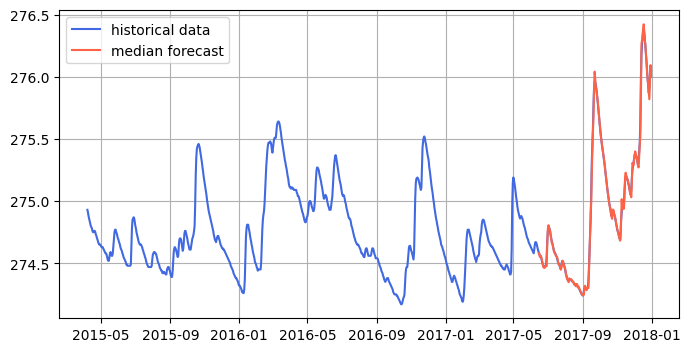

In [94]:
# Visualise time series with predictions with one day ahead
plt.figure(figsize=(8, 4))
plt.plot(relative_aquifer['date'][-1000:], relative_aquifer['altitude'][-1000:], color="royalblue", label="historical data")
plt.plot(relative_aquifer['date'][-day_len:], day_1, color="tomato", label="median forecast")
plt.legend()
plt.grid()
plt.show()

Evaluation

In [168]:
r2_1_day = r2_score(relative_aquifer['altitude'][-day_len:], day_1)
r2_2_day = r2_score(relative_aquifer['altitude'][-day_len:], day_2)
r2_3_day = r2_score(relative_aquifer['altitude'][-day_len:], day_3)
r2_4_day = r2_score(relative_aquifer['altitude'][-day_len:], day_4)
r2_5_day = r2_score(relative_aquifer['altitude'][-day_len:], day_5)

print(f"1 day ahead: {r2_1_day}")
print(f"2 days ahead: {r2_2_day}")
print(f"3 days ahead: {r2_3_day}")
print(f"4 days ahead: {r2_4_day}")
print(f"5 days ahead: {r2_5_day}")

1 day ahead: 0.9986858991064769
2 days ahead: 0.992765053640022
3 days ahead: 0.9790116361788382
4 days ahead: 0.9560255499579082
5 days ahead: 0.9241889741812146


Averaging results for multiple aquifer stations

In [136]:
aquifers_list = [85065, 85065]

In [178]:
pipeline = ChronosPipeline.from_pretrained(
    "amazon/chronos-t5-large",
    device_map="cuda",
    torch_dtype=torch.bfloat16,
)

horizon = 5
history = 100

# List for r2 results for different prediction horizons
r2_scores = [[] for _ in range(5)]

for aquifer, data in aquifer_by_stations.items():
    # List for storing the predictions
    predictions = [[] for _ in range(5)]

    day_len = 200

    # Iterate from day_len days before the end, to the last day
    for i in range(day_len + 4, 0, -1):
        y = aquifer_by_stations[aquifer]['altitude_diff'].values
        y = torch.tensor(y[:-i])

        forecast = pipeline.predict(
            context= y,
            prediction_length=horizon,
            num_samples=20
        )

        low, median, high = np.quantile(forecast[0].numpy(), [0.1, 0.5, 0.9], axis=0)

        # Store the results for every prediction horizon separately
        for i in range(5):
            predictions[i].append(median[i])
    
    # Clean up the results
    predictions[0] = predictions[0][-200:]
    predictions[1] = predictions[1][3:-1]
    predictions[2] = predictions[2][2:-2]
    predictions[3] = predictions[3][1:-3]
    predictions[4] = predictions[4][0:-4]

    # Calculate the r2 scores and store them in a list
    for i in range(5):
        r2_scores[i].append(r2_score(aquifer_by_stations[aquifer]['altitude_diff'][-day_len:], predictions[i]))

In [179]:
# Calculate the average r2 score
r2_average =  []
std_dev = []

for i in range(5):
    r2_average.append(np.mean(r2_scores[i]))
    std_dev.append(np.std(r2_scores[i]))

In [180]:
r2_average

[0.3606086903379666,
 0.1301634750541993,
 0.06699220089370284,
 0.004305516683573829,
 -0.06857471242441213]

In [181]:
std_dev

[0.32005274260580185,
 0.3258197260688206,
 0.2669439582462552,
 0.23293469263795383,
 0.23240143685624878]

In [182]:
r2_scores[0]

[0.14216130049172448,
 0.35890079054588153,
 0.20675795295218546,
 0.024716986687167597,
 0.13803812935604454,
 0.2928418059139889,
 -0.001337253408857375,
 0.23111262411625977,
 0.46425064779336034,
 0.16861629560479297,
 0.5322090144006651,
 0.13781485632579982,
 0.09520198648891076,
 0.8583716556679831,
 -0.006700040311215405,
 0.07178905080951947,
 0.031525802671077074,
 0.3800143815753476,
 0.09641910029073808,
 -0.10296031911195413,
 -0.10108037941674364,
 0.4640174660954898,
 0.25535398891544725,
 0.740961854472451,
 0.6898522532935161,
 -0.08742040808723339,
 0.15578551594572165,
 0.8910345169083264,
 0.8087128215936759,
 0.125881891247848,
 0.6501182053851372,
 0.1987798880809032,
 0.1855432867531983,
 0.28648798518067653,
 0.9142095748644803,
 0.7819637854343942,
 0.741094841676929,
 0.7040952997683185,
 0.2613395129076631,
 0.8477947396618102,
 -0.07777476613447387,
 0.7795930152268274,
 0.05607831592836465,
 0.16267362110988948,
 0.5931543598628408,
 0.22881370731838446,
 0

In [183]:
aquifer_by_stations.keys()

dict_keys([1005, 1010, 1015, 1022, 1055, 1065, 1085, 5011, 10005, 10055, 15045, 15080, 16005, 20020, 25013, 30005, 30010, 30015, 30040, 30050, 30055, 40015, 45030, 50010, 50061, 55080, 60050, 65015, 65065, 70010, 70030, 70045, 75020, 80020, 80030, 80035, 80050, 80055, 80062, 80075, 80080, 80085, 85012, 85030, 85040, 85050, 85063, 85064, 85065, 90040, 90055, 90099, 95030, 95035, 95045, 95048, 95055, 95060])

In [184]:
scores = dict(zip(aquifer_by_stations.keys(), r2_scores[0]))
scores = {k: v for k, v in sorted(scores.items(), key=lambda item: item[1])}

In [185]:
# Save the dictionaray to a joblib file
#joblib.dump(scores, 'chronos_tiny_results.joblib')